<a href="https://colab.research.google.com/github/hibaessid/learningRepo/blob/main/kagellnotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hibaessid","key":"9d7efc0c5bc56d46c6624db6404b52e5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d awsaf49/brats2020-training-data


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
100% 6.74G/6.76G [01:35<00:00, 122MB/s]
100% 6.76G/6.76G [01:35<00:00, 76.1MB/s]


In [ ]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('/content/brats2020-training-data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brats2020-training-data')


In [ ]:
import os

# List files in the extracted directory
extracted_dir = '/content/brats2020-training-data'
os.listdir(extracted_dir)

['BraTS20 Training Metadata.csv', 'BraTS2020_training_data']

In [ ]:
!pip install h5py


In [ ]:
import numpy as np
import os
import h5py

# Directory containing .h5 files
directory = "/content/brats2020-training-data/BraTS2020_training_data/content/data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names: {h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[0])  # Changed index to 0 to avoid IndexError
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}: {type(file[key][()])}")
            print(f"Shape of {key}: {file[key].shape}")
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")


Found 57195 .h5 files:
Example file names: ['volume_330_slice_122.h5', 'volume_68_slice_153.h5', 'volume_184_slice_26.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 6.858022090013969
Array min val: -0.38529389261637487

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 0
Array min val: 0


Image shape: torch.Size([4, 240, 240])
Mask shape: torch.Size([3, 240, 240])


<ipython-input-16-3478112fa3b9>:48: RuntimeWarning: invalid value encountered in divide
  image[c] = (image[c] - image[c].min()) / (image[c].max() - image[c].min())
<ipython-input-16-3478112fa3b9>:48: RuntimeWarning: invalid value encountered in divide
  image[c] = (image[c] - image[c].min()) / (image[c].max() - image[c].min())


Batch 1:
Images shape: torch.Size([4, 4, 240, 240])
Masks shape: torch.Size([4, 3, 240, 240])


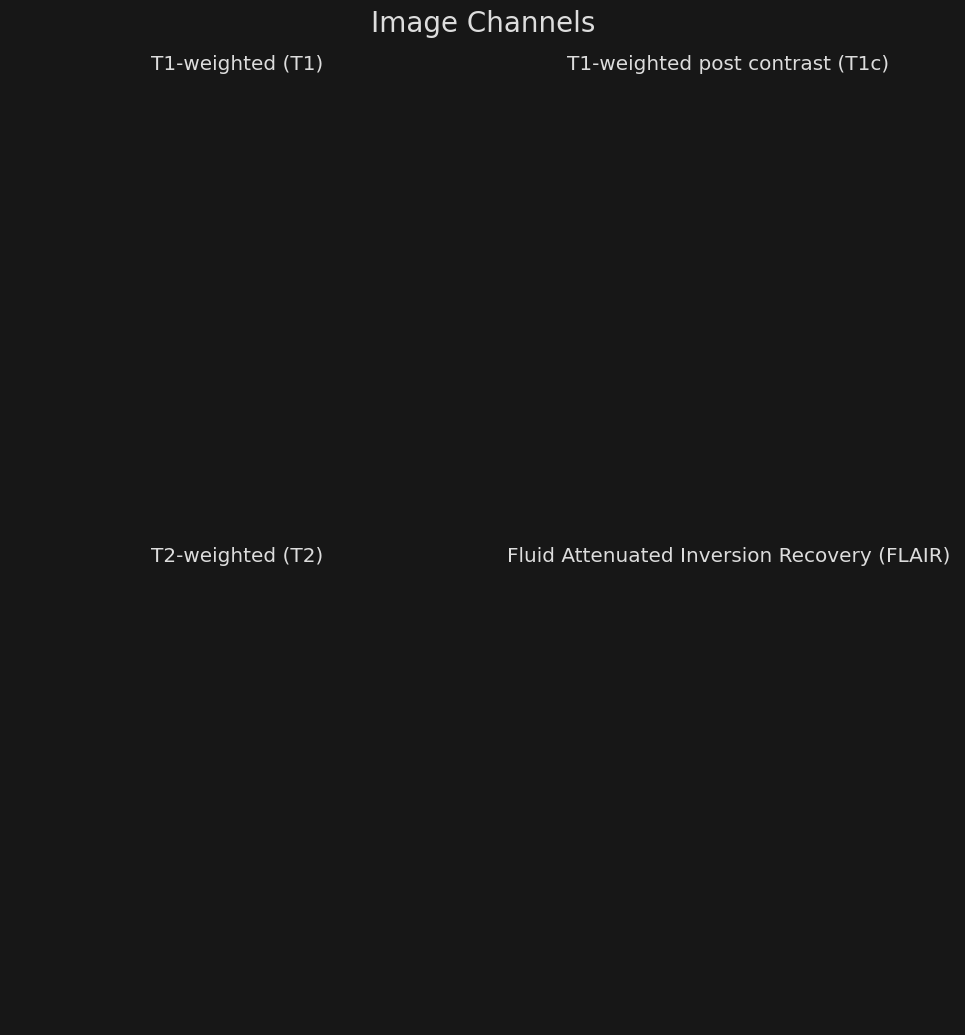

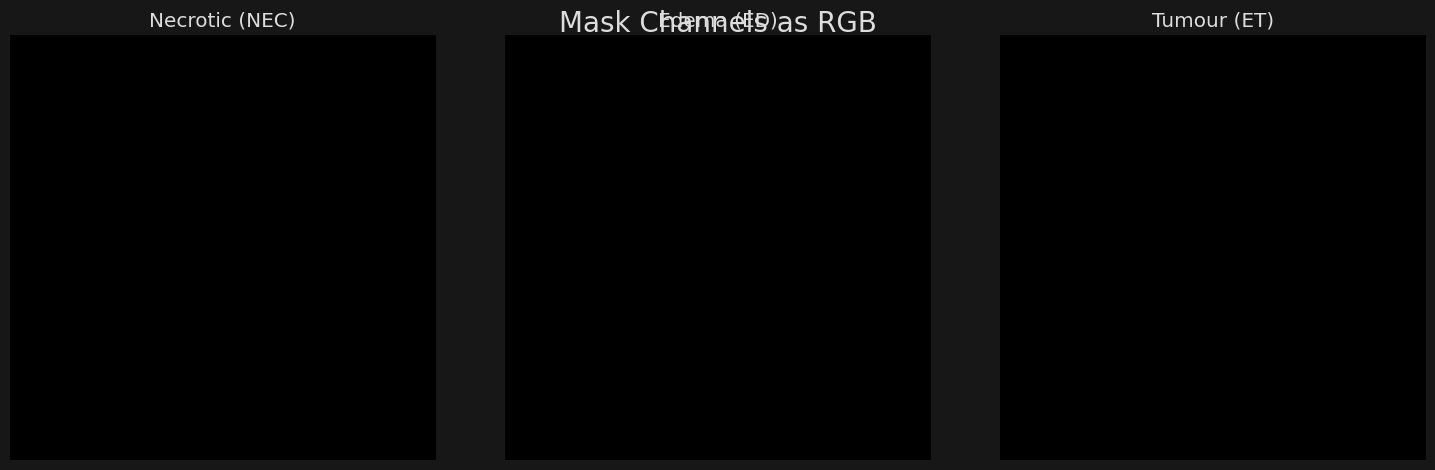

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


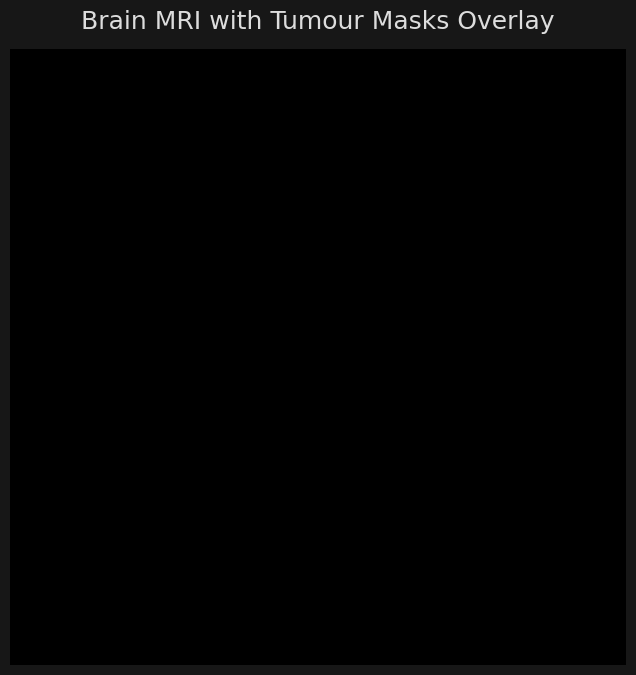

Batch 2:
Images shape: torch.Size([4, 4, 240, 240])
Masks shape: torch.Size([4, 3, 240, 240])


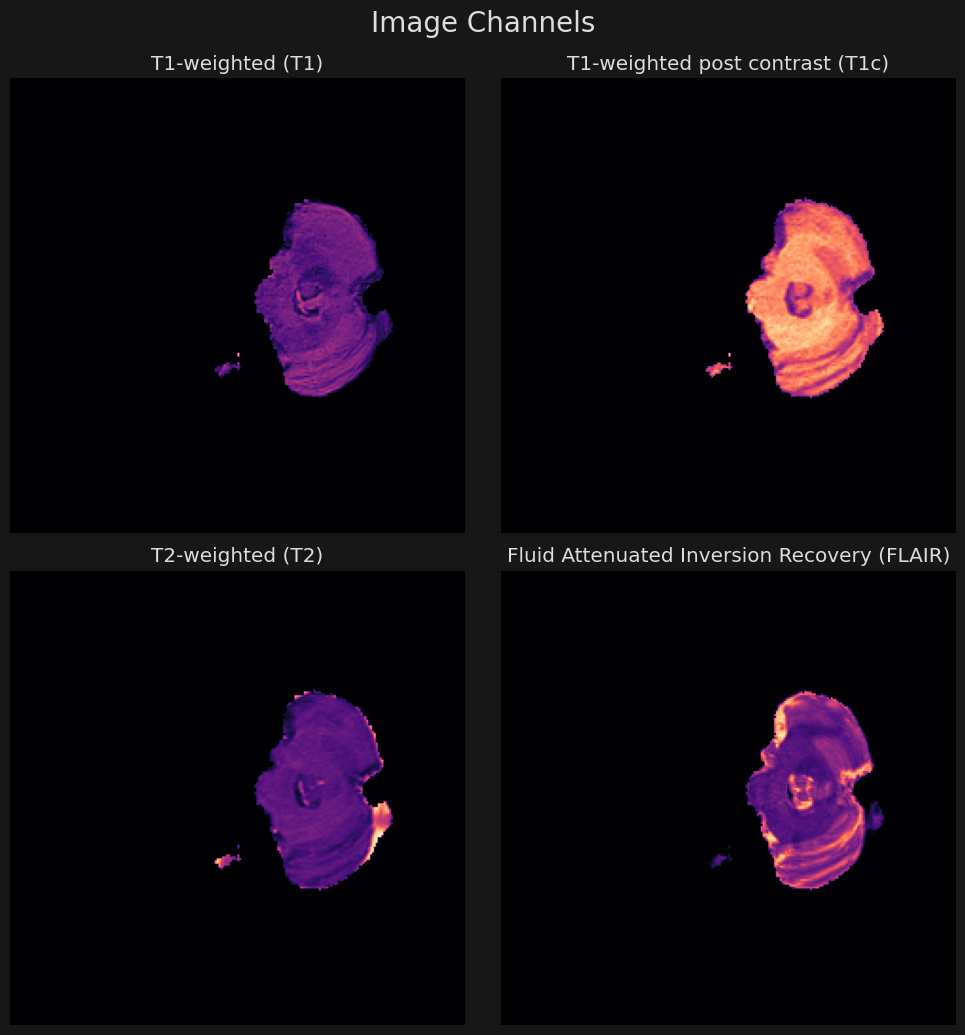

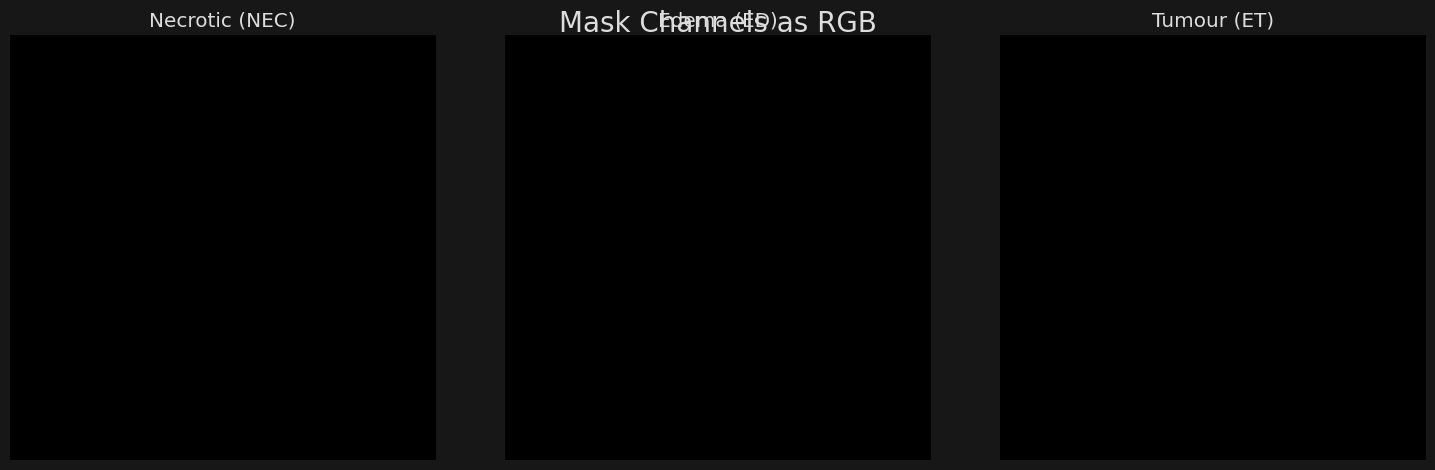

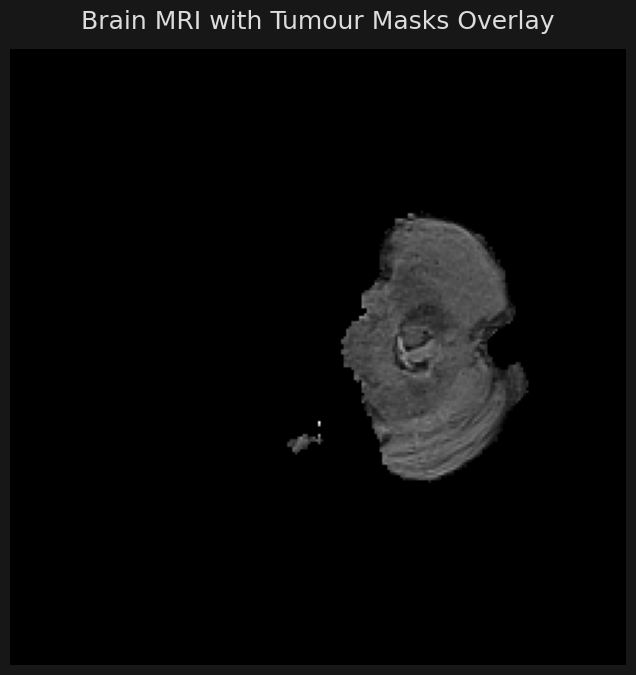

<ipython-input-16-3478112fa3b9>:48: RuntimeWarning: invalid value encountered in divide
  image[c] = (image[c] - image[c].min()) / (image[c].max() - image[c].min())


Batch 3:
Images shape: torch.Size([4, 4, 240, 240])
Masks shape: torch.Size([4, 3, 240, 240])


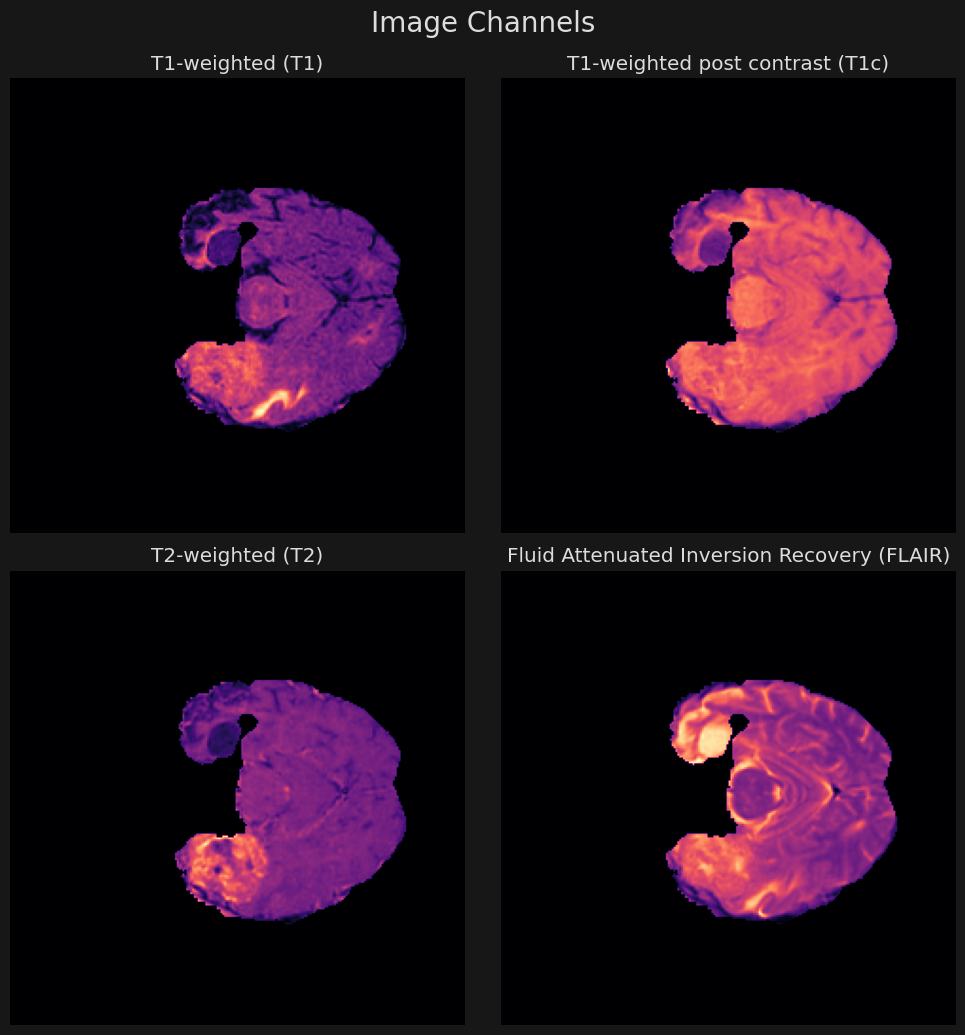

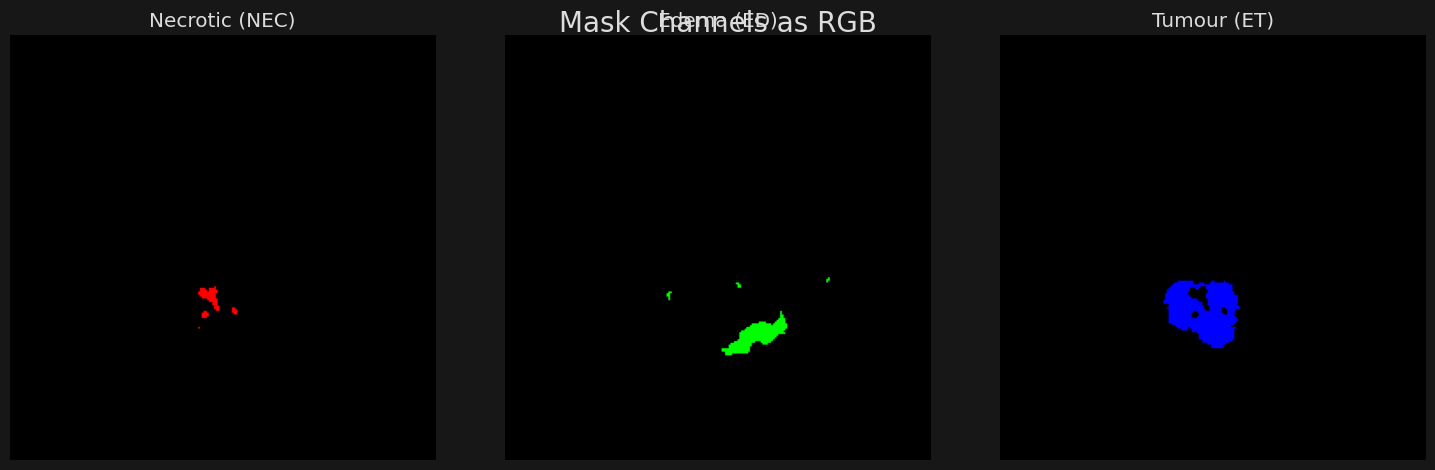

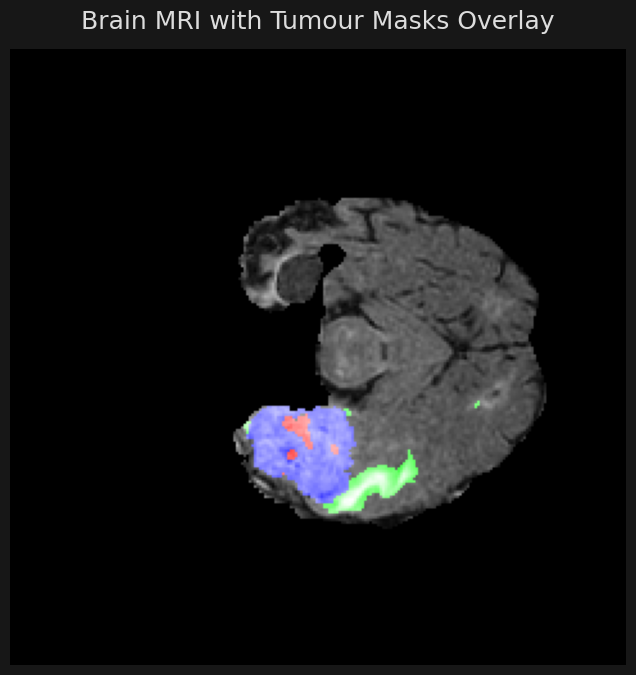

In [ ]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color'] = '#DDDDDD'

class BrainTumorDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
        self.transform = transform

    def __len__(self):
        return len(self.h5_files)


    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.h5_files[idx])
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

        # Transpose the image and mask to have channels first
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        # Normalize the image
        image = self.normalize_image(image)

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.uint8)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def normalize_image(self, image):
        image = image.astype(np.float32)
        for c in range(image.shape[0]):
            image[c] = (image[c] - image[c].min()) / (image[c].max() - image[c].min())
        return image

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = ['Reds', 'Greens', 'Blues']
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Scale to 255 for visualization
        ax.imshow(rgb_mask, cmap=colors[idx])
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.zeros_like(rgb_image)
    color_mask[..., 0] = mask[0, :, :]  # Red channel
    color_mask[..., 1] = mask[1, :, :]  # Green channel
    color_mask[..., 2] = mask[2, :, :]  # Blue channel

    rgb_image = np.where(color_mask, color_mask, rgb_image)

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()

# Directory containing .h5 files
directory = "/content/brats2020-training-data/BraTS2020_training_data/content/data"

# Instantiate the dataset
dataset = BrainTumorDataset(directory)

# Test the dataset
image, mask = dataset[0]
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

# Define data loader parameters
batch_size = 4
shuffle = True
num_workers = 2

# Create the data loader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Test the data loader
for i, (images, masks) in enumerate(dataloader):
    print(f"Batch {i + 1}:")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    display_image_channels(images[0].numpy())
    display_mask_channels_as_rgb(masks[0].numpy())
    overlay_masks_on_image(images[0].numpy(), masks[0].numpy())
    if i == 2:
        break  # Test only two batches


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import h5py

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:
            np.random.seed(1)  # Set seed for reproducibility
        np.random.shuffle(self.file_paths)  # Shuffle the file paths

    def __len__(self):
        return len(self.file_paths)  # Return the number of files

    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]

            # Reshape: (H, W, C) -> (C, H, W)
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))

            # Adjusting pixel values for each channel in the image so they are between 0 and 1
            for i in range(image.shape[0]):  # Iterate over channels
                min_val = np.min(image[i])
                image[i] = image[i] - min_val  # Shift values to ensure min is 0
                max_val = np.max(image[i]) + 1e-4  # Scale values to ensure max is 1
                image[i] = image[i] / max_val

            # Convert to float and scale the whole image
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

# Build .h5 file paths from directory containing .h5 files
directory = "/content/brats2020-training-data/BraTS2020_training_data/content/data"
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

# Example output:
# Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
# Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


In [ ]:
from torch import nn

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d( 8*n_filters, 16*n_filters, kernel_size=(3,3), stride=1, padding=1),
            activation,
            nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=(3,3), stride=1, padding=1),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock( 8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock( 4*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock( 2*n_filters, 1*n_filters, activation)

        # Output projection
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)


    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x      = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x      = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x      = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x      = self.downsample(skip_4)

        # Bottleneck
        x      = self.bottleneck(x)

        # Decoder
        x      = self.upsample(x)
        x      = torch.cat((x, skip_4), axis=1)  # Skip connection
        x      = self.dec_block_4(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_3), axis=1)  # Skip connection
        x      = self.dec_block_3(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_2), axis=1)  # Skip connection
        x      = self.dec_block_2(x)
        x      = self.upsample(x)
        x      = torch.cat((x, skip_1), axis=1)  # Skip connection
        x      = self.dec_block_1(x)
        x      = self.output(x)
        return x

# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)

In [ ]:
def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
    """
    This function trains the UNet model using the provided training and validation data loaders and configuration parameters.

    Steps involved in the training loop:
    1. **Function Definition**: Define the training function.
    2. **Configuration Parameters**: Extract training configurations such as device, number of epochs, learning rate, etc.
    3. **Model Setup**: Initialize the model, optimizer, and loss function, and move the model to the specified device.
    4. **Initialize Loss Tracking**: Lists to store the average training and validation losses for each epoch.
    5. **Training Loop**: Loop through the specified number of epochs.
    6. **Learning Rate Decay**: Adjust the learning rate each epoch.
    7. **Training Step**: For each batch, perform a forward pass, calculate the loss, and update the model parameters.
    8. **Forward Pass and Loss Calculation**: Move inputs and targets to the device, generate predictions, calculate the batch loss, and accumulate the batch loss.
    9. **Backward Pass and Optimization**: Zero the gradients, perform backpropagation, and update the model parameters.
    10. **Break Condition for Training Batches**: Stop processing batches once the specified number of batches per epoch is reached.
    11. **Store Training Loss**: Append the cumulative training loss for the epoch.
    12. **Validation Step**: Set the model to evaluation mode, loop through the validation batches, and calculate the validation loss.
    13. **Forward Pass and Loss Calculation (Validation)**: Move inputs and targets to the device, generate predictions, and calculate the batch loss.
    14. **Break Condition for Validation Batches**: Stop processing batches once the specified number of batches per epoch is reached.
    15. **Store Validation Loss**: Append the cumulative validation loss for the epoch.
    16. **Print Epoch Summary**: Print the training and validation losses for each epoch.
    17. **Training Completion**: Print training completion message and return training and validation losses.

    Returns:
    - train_epoch_losses: List of training losses for each epoch.
    - val_epoch_losses: List of validation losses for each epoch.
    """

    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []

    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx >= batches_per_epoch:
                if verbose: print()
                break
        train_epoch_losses.append(train_epoch_loss)

        # Validation step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                if verbose: print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()

                if val_batch_idx >= batches_per_epoch:
                    if verbose: print()
                    break
        val_epoch_losses.append(val_epoch_loss)

        if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")

    print("Training complete.")
    return train_epoch_losses, val_epoch_losses


In [ ]:
# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          12,
    'batch_size':        32,
    'learning_rate':     1e-3,
    'batches_per_epoch': 50,
    'lr_decay_factor':   1
}

# Create UNet model and count params
model = UNet()
count_parameters(model)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

Total Parameters: 5,496,451

Training...
Training complete.


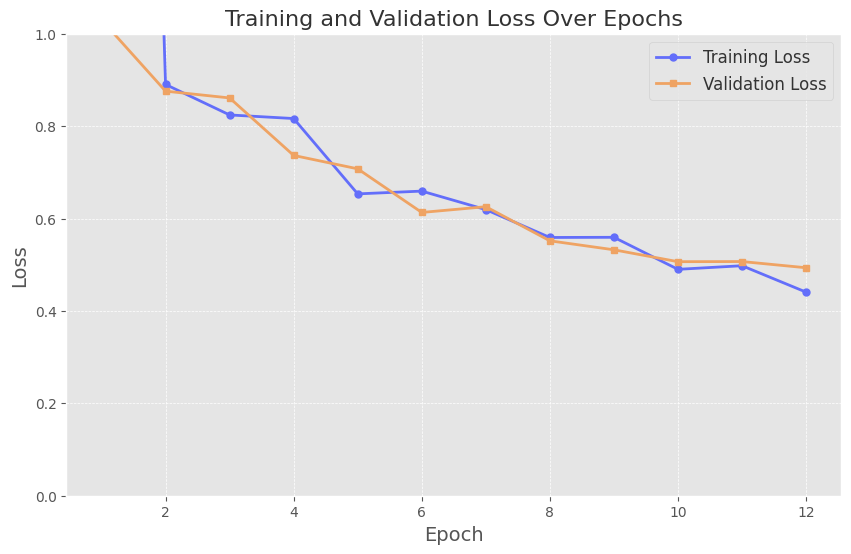

In [ ]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)

    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_learning_curves(train_epoch_losses, val_epoch_losses)

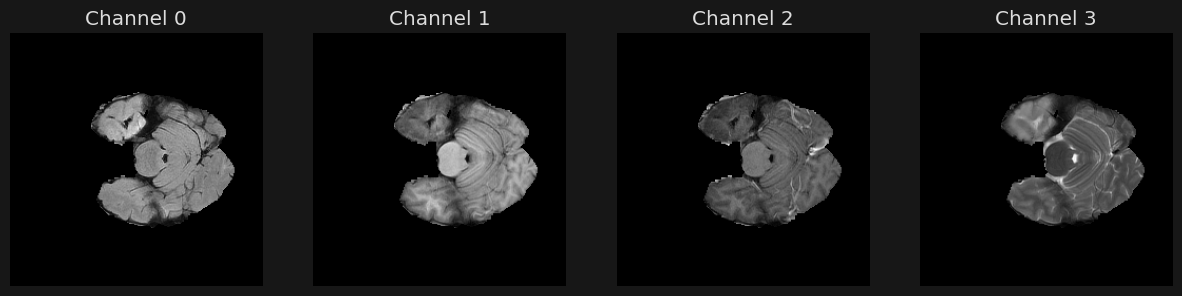

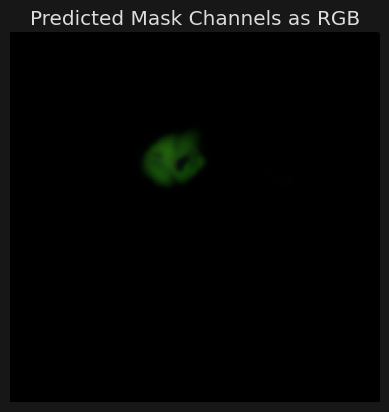

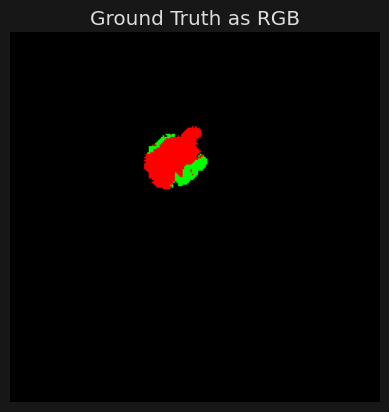

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_image_channels(image):
    # Function to display the input image channels
    fig, axs = plt.subplots(1, image.shape[0], figsize=(15, 5))
    for i in range(image.shape[0]):
        axs[i].imshow(image[i], cmap='gray')
        axs[i].set_title(f'Channel {i}')
        axs[i].axis('off')
    plt.show()

def display_mask_channels_as_rgb(mask, title):
    # Function to display the mask channels as RGB
    mask_rgb = np.stack([mask[i] for i in range(mask.shape[0])], axis=-1)
    plt.imshow(mask_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    model.eval()
    with torch.no_grad():
        test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color'] = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)


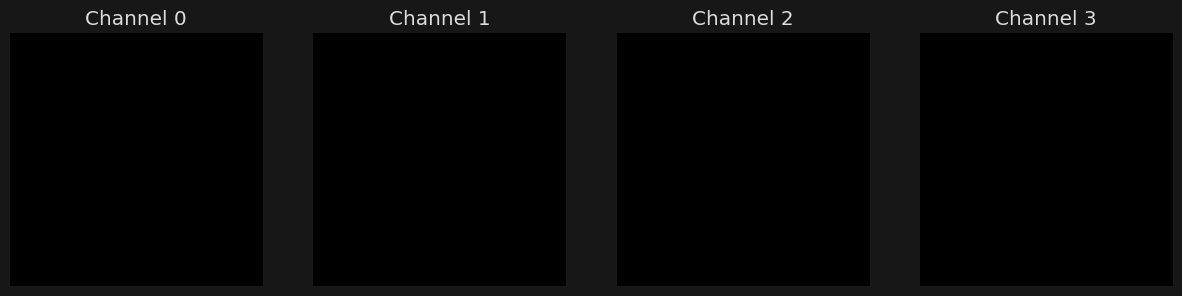

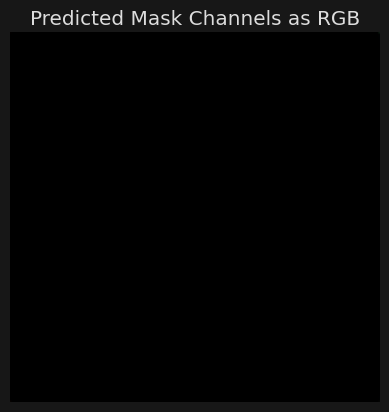

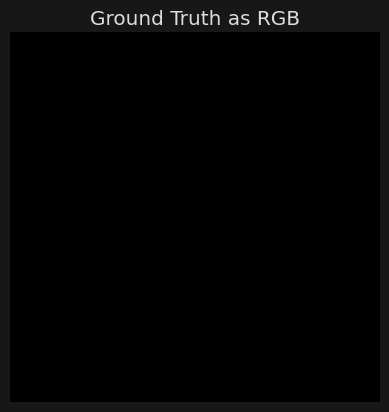

In [ ]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')


# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

Upgraded UNet¶
Our current UNet model is smaller than the model used in UNet, but our model already has a fairly large 5.5 million parameters. Instead of directly increasing the size of our model, we'll work in some more modern computer vision tweaks to it that should improve performance.

Separable convolution layers
Popularised by Chollet in Xception, we're going to use separable convolution layers rather than conventional convolution layers.

Batch normalisation
Batch norm has become a staple inclusion in most convnet architectures.

Larger kernel sizes
ConvNeXt found that using larger kernel sizes of (7x7) outperformed 3x3 kernels in their experiments. We'll adopt this change.

Inverse bottlenecks
From MobileNetV2, we're going to use inverse bottlenecks after our depthwise convolution, to improve the parameter efficiency in our model.

Additive skip connections
Rather than using a concat skip connection, we'll use an additive one. This change reduces the number of parameters as well and should give the model a clearer residual signal.

Learning rate decay
A standard inclusion to help more powerful models refine their predictions.

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4

        self.encoder_block = nn.Sequential(
            # ConvNeXt style blocks
            nn.Conv2d(in_channels,                   in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(out_channels,                 out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4

        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,                    in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,    expansion_ratio*in_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*in_channels,   out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(out_channels,                  out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels,  out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.decoder_block(x)


class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),

            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)

        # Output projection
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x      = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x      = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x      = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x      = self.downsample(skip_4)

        # Bottleneck
        x      = self.bottleneck(x)

        # Decoder
        x      = self.upsample(x)
        x      = torch.add(x, skip_4)  # Skip connection
        x      = self.dec_block_4(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_3)  # Skip connection
        x      = self.dec_block_3(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_2)  # Skip connection
        x      = self.dec_block_2(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_1)  # Skip connection
        x      = self.dec_block_1(x)
        x      = self.output(x)
        return x

Total Parameters: 3,082,739

Training...
Training complete.


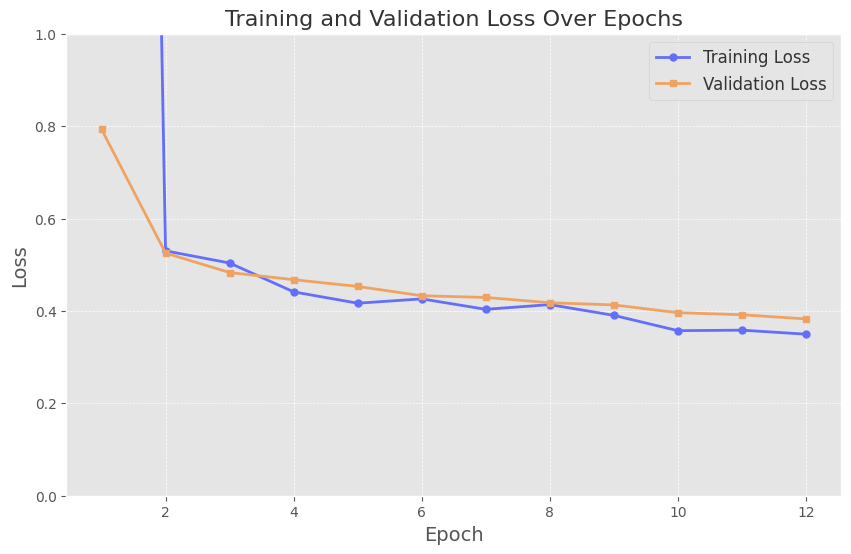

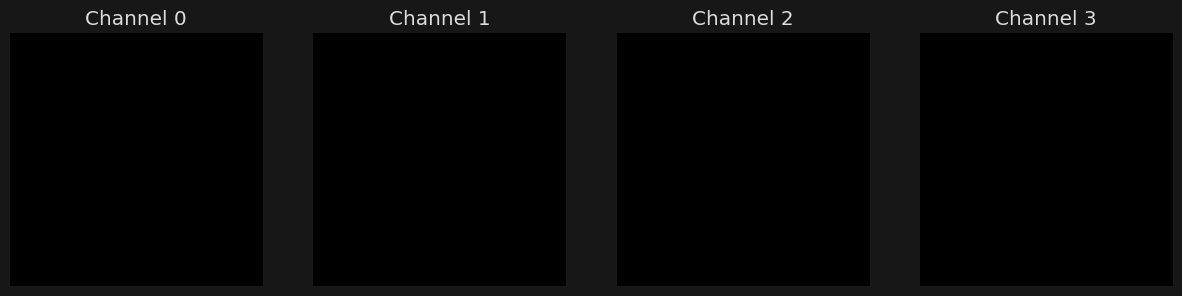

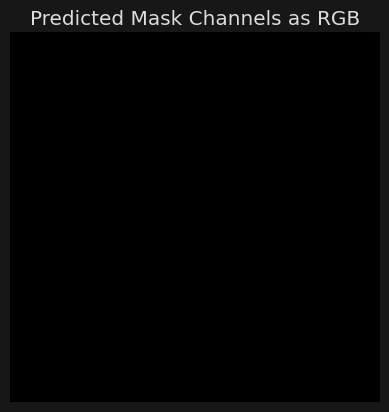

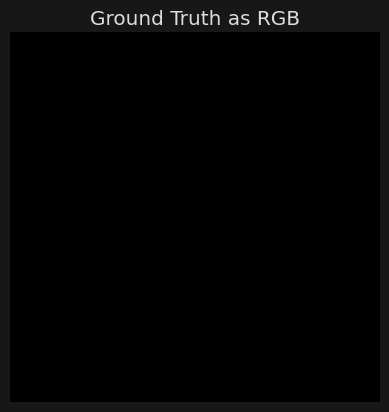

In [ ]:

# Delete old model and clear GPU cache to release memory
del model
torch.cuda.empty_cache()

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          12,
    'batch_size':        32,
    'learning_rate':     1e-3,
    'batches_per_epoch': 50,
    'lr_decay_factor':   0.85
}

# Create UNet model and count params
model = UNet2()
count_parameters(model)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

# Plot learning curves
plot_learning_curves(train_epoch_losses, val_epoch_losses)

# Performance on test image
display_test_sample(model, test_input, test_target, device)



In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4

        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels,                   in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(out_channels,                 out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.encoder_block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4

        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,                    in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,    expansion_ratio*in_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*in_channels,   out_channels, kernel_size=(1,1), stride=1),

            nn.Conv2d(out_channels,                  out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels,  out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.decoder_block(x)

class AttentionResBlock(nn.Module):
    def __init__(self, in_channels, activation=nn.ReLU()):
        super().__init__()
        self.query_conv     = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=1)
        self.key_conv       = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=2)
        self.attention_conv = nn.Conv2d(in_channels, 1, kernel_size=(1,1), stride=1)

        self.upsample       = nn.UpsamplingBilinear2d(scale_factor=2)
        self.activation     = activation

    def forward(self, query, key, value):
        query = self.query_conv(query)
        key   = self.key_conv(key)

        combined_attention = self.activation(query + key)
        attention_map = torch.sigmoid(self.attention_conv(combined_attention))
        upsampled_attention_map = self.upsample(attention_map)
        attention_scores = value * upsampled_attention_map
        return attention_scores


class AttentionUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),

            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)

        # Output projection
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        # Attention res blocks
        self.att_res_block_1 = AttentionResBlock(1*n_filters)
        self.att_res_block_2 = AttentionResBlock(2*n_filters)
        self.att_res_block_3 = AttentionResBlock(4*n_filters)
        self.att_res_block_4 = AttentionResBlock(8*n_filters)

    def forward(self, x):
        # Encoder
        enc_1 = self.enc_block_1(x)
        x     = self.downsample(enc_1)
        enc_2 = self.enc_block_2(x)
        x     = self.downsample(enc_2)
        enc_3 = self.enc_block_3(x)
        x     = self.downsample(enc_3)
        enc_4 = self.enc_block_4(x)
        x     = self.downsample(enc_4)

        # Bottleneck
        dec_4 = self.bottleneck(x)

        # Decoder
        x     = self.upsample(dec_4)
        att_4 = self.att_res_block_4(dec_4, enc_4, enc_4)  # QKV
        x     = torch.add(x, att_4)  # Add attention masked value rather than concat

        dec_3 = self.dec_block_4(x)
        x     = self.upsample(dec_3)
        att_3 = self.att_res_block_3(dec_3, enc_3, enc_3)
        x     = torch.add(x, att_3)  # Add attention

        dec_2 = self.dec_block_3(x)
        x     = self.upsample(dec_2)
        att_2 = self.att_res_block_2(dec_2, enc_2, enc_2)
        x     = torch.add(x, att_2)  # Add attention

        dec_1 = self.dec_block_2(x)
        x     = self.upsample(dec_1)
        att_1 = self.att_res_block_1(dec_1, enc_1, enc_1)
        x     = torch.add(x, att_1)  # Add attention

        x     = self.dec_block_1(x)
        x     = self.output(x)
        return x

Total Parameters: 3,258,263

Training...
Training complete.


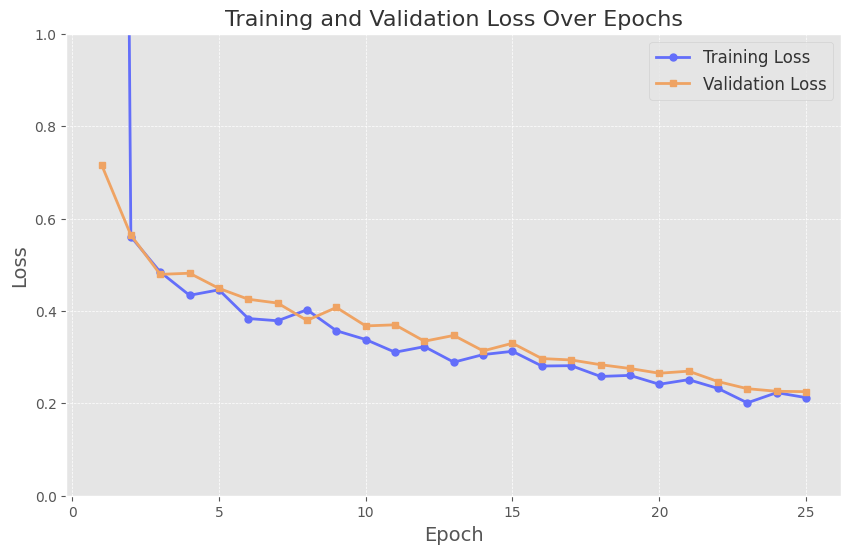

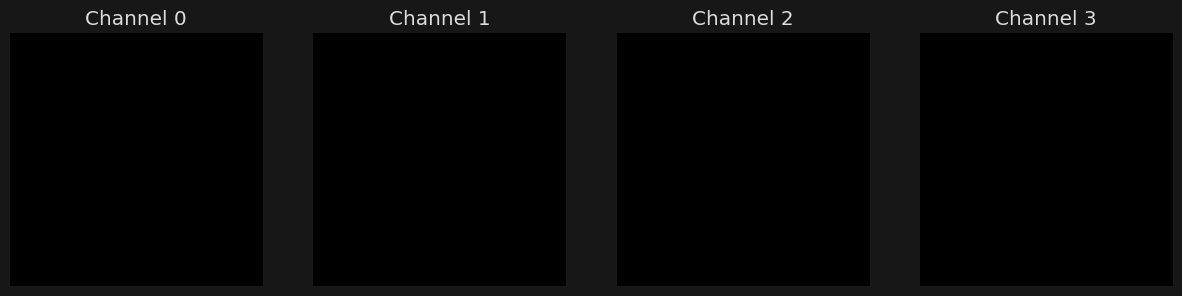

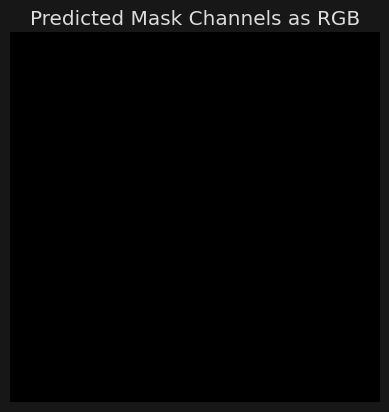

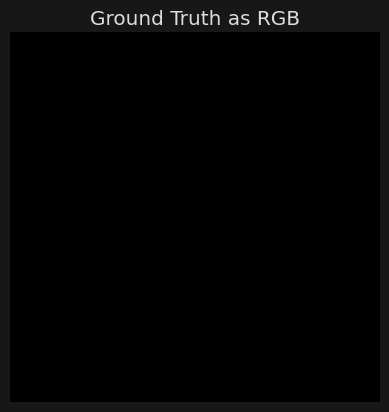

In [ ]:
# Delete old model and clear GPU cache to release memory
del model
torch.cuda.empty_cache()

# Settings for training
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          25,
    'batch_size':        32,
    'learning_rate':     1e-3,
    'batches_per_epoch': 50,
    'lr_decay_factor':   0.93
}

# Create UNet model and count params
model = AttentionUNet()
count_parameters(model)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

# Save weights
save_model(model, 'attention-unet-weights.pth')

# Plot learning curves
plot_learning_curves(train_epoch_losses, val_epoch_losses)

# Performance on test image
display_test_sample(model, test_input, test_target, device)

Visualising Attention¶
We can easily visualise attention by modifying our code to return the attention mask during the forward pass, so we can plot it.

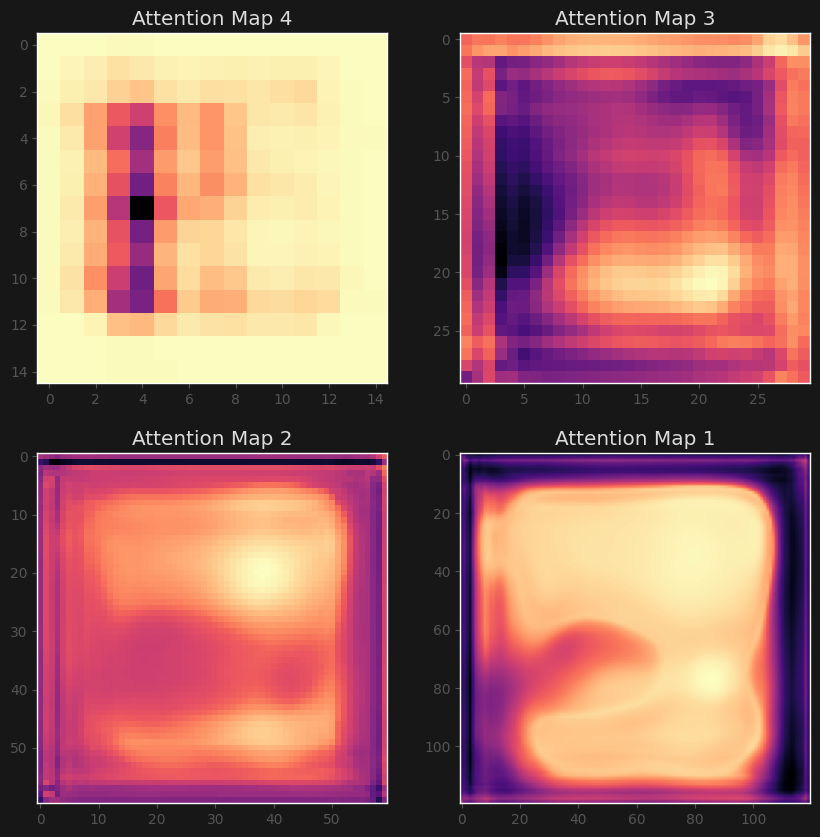

In [ ]:
class AttentionResBlock(nn.Module):
    def __init__(self, in_channels, activation=nn.ReLU()):
        super().__init__()
        self.query_conv     = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=1)
        self.key_conv       = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=2)
        self.attention_conv = nn.Conv2d(in_channels, 1, kernel_size=(1,1), stride=1)

        self.upsample       = nn.UpsamplingBilinear2d(scale_factor=2)
        self.activation     = activation

    def forward(self, query, key, value):
        query = self.query_conv(query)
        key   = self.key_conv(key)

        combined_attention = self.activation(query + key)
        attention_map = torch.sigmoid(self.attention_conv(combined_attention))
        upsampled_attention_map = self.upsample(attention_map)
        attention_scores = value * upsampled_attention_map
        return attention_scores, attention_map  # Additionally return attention map


class AttentionVisUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()

        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),

            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)

        # Output projection
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        # Attention res blocks
        self.att_res_block_1 = AttentionResBlock(1*n_filters)
        self.att_res_block_2 = AttentionResBlock(2*n_filters)
        self.att_res_block_3 = AttentionResBlock(4*n_filters)
        self.att_res_block_4 = AttentionResBlock(8*n_filters)

    def forward(self, x):
        # Encoder
        enc_1 = self.enc_block_1(x)
        x     = self.downsample(enc_1)
        enc_2 = self.enc_block_2(x)
        x     = self.downsample(enc_2)
        enc_3 = self.enc_block_3(x)
        x     = self.downsample(enc_3)
        enc_4 = self.enc_block_4(x)
        x     = self.downsample(enc_4)

        # Bottleneck
        dec_4 = self.bottleneck(x)

        # Decoder
        x     = self.upsample(dec_4)
        att_4, map_4 = self.att_res_block_4(dec_4, enc_4, enc_4)  # Get attention maps
        x     = torch.add(x, att_4)  # Add attention masked value rather than concat

        dec_3 = self.dec_block_4(x)
        x     = self.upsample(dec_3)
        att_3, map_3 = self.att_res_block_3(dec_3, enc_3, enc_3)
        x     = torch.add(x, att_3)  # Add attention

        dec_2 = self.dec_block_3(x)
        x     = self.upsample(dec_2)
        att_2, map_2 = self.att_res_block_2(dec_2, enc_2, enc_2)
        x     = torch.add(x, att_2)  # Add attention

        dec_1 = self.dec_block_2(x)
        x     = self.upsample(dec_1)
        att_1, map_1 = self.att_res_block_1(dec_1, enc_1, enc_1)
        x     = torch.add(x, att_1)  # Add attention

        x     = self.dec_block_1(x)
        x     = self.output(x)
        return x, map_4, map_3, map_2, map_1  # Return attention maps for plotting

# Build attention visualisation model, load to device then load trained weights
att_vis_unet = AttentionVisUNet().to(device)
att_vis_unet.load_state_dict(torch.load('attention-unet-weights.pth'))

# Forward pass to get attention maps
_, map_4, map_3, map_2, map_1 = att_vis_unet(test_input.to(device))

# Plot atttention maps
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for idx, (ax, att_map) in enumerate(zip(axes.flatten(), [map_4, map_3, map_2, map_1])):
    power = 2**(3 - idx)
    ax.imshow(att_map.detach().cpu().numpy().reshape(120//power,120//power), cmap='magma')
    ax.set_title(f'Attention Map {4-idx}')
    ax.grid(False)